In [159]:
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from deap import base, creator, tools
import random
import math

# This is BAD (do not use)

In [160]:
csv_file_path = 'sim_with_razor.csv'
column_name = 'Dark Photon Produced'

# Open the CSV file
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    true_rows = []
    
    for row in reader:
        if row[column_name].lower() == 'true':
            true_rows.append(row)


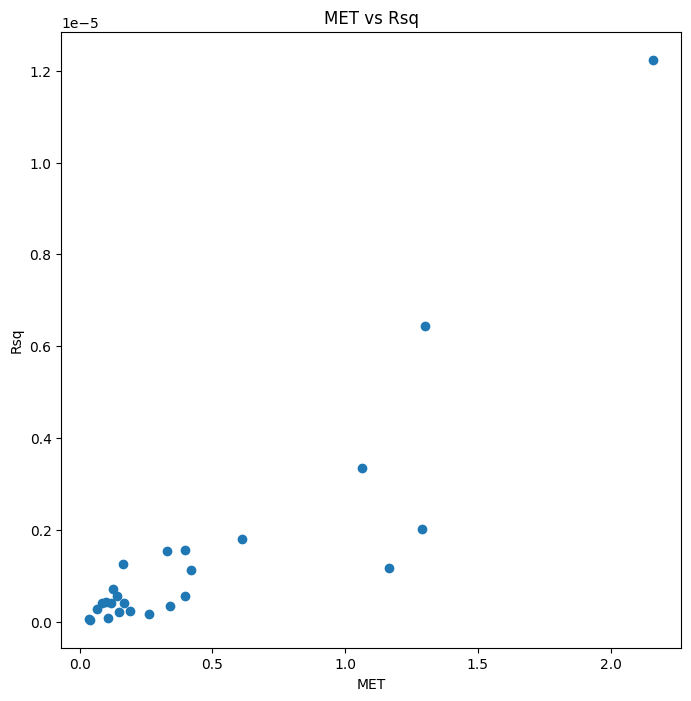

In [161]:
HT = [float(row['HT']) for row in true_rows]
MET = [float(row['MET']) for row in true_rows]
Rsq = [float(row['Rsq']) for row in true_rows]

# Creating scatter plots
plt.figure(figsize=(8, 8))  

# MET vs Rsq
plt.scatter(MET, Rsq)
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('MET vs Rsq')

plt.show()

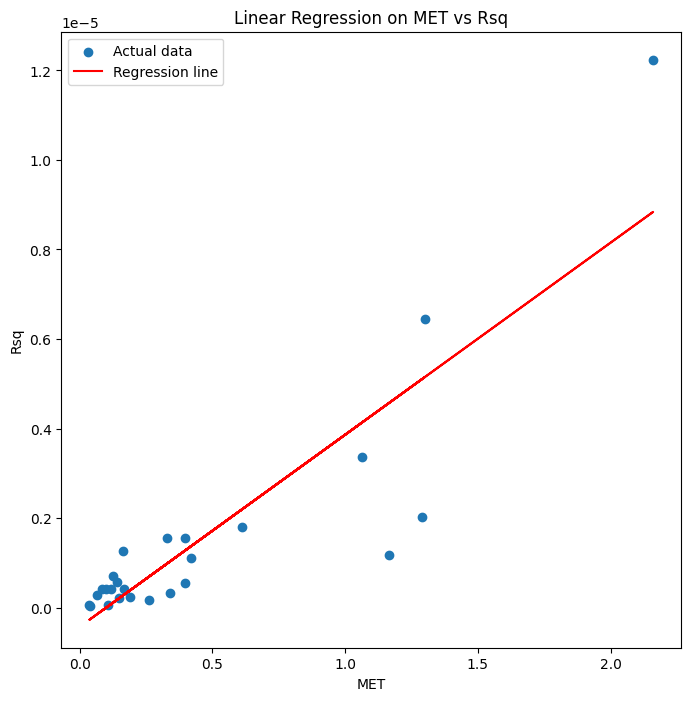

In [162]:
MET_array = np.array(MET).reshape(-1, 1)  # Features need to be 2D for sklearn
Rsq_array = np.array(Rsq)  # Target can be 1D

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(MET_array, Rsq_array)

# Predictions for the line
Rsq_pred = model.predict(MET_array)

# Plotting MET vs Rsq with the regression line
plt.figure(figsize=(8, 8))
plt.scatter(MET, Rsq, label='Actual data')
plt.plot(MET, Rsq_pred, color='red', label='Regression line')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('Linear Regression on MET vs Rsq')
plt.legend()

plt.show()

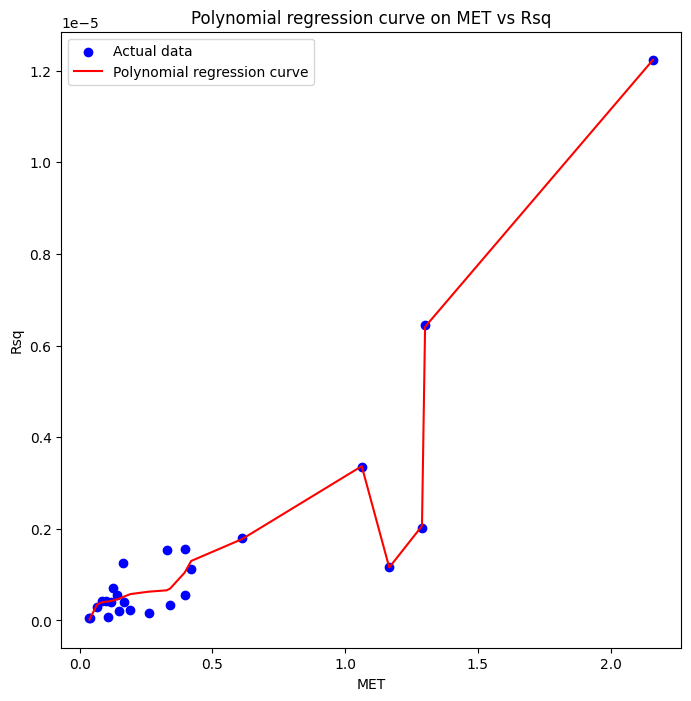

In [163]:
poly = PolynomialFeatures(degree=10)
MET_poly = poly.fit_transform(MET_array)

model_poly = LinearRegression()
model_poly.fit(MET_poly, Rsq_array)

Rsq_pred_poly = model_poly.predict(MET_poly)

sorted_zip = sorted(zip(MET, Rsq_pred_poly))
MET_sorted, Rsq_pred_poly_sorted = zip(*sorted_zip)

plt.figure(figsize=(8, 8))
plt.scatter(MET, Rsq, color='blue', label='Actual data')
plt.plot(MET_sorted, Rsq_pred_poly_sorted, color='red', label='Polynomial regression curve')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.title('Polynomial regression curve on MET vs Rsq')
plt.legend()

plt.show()

In [164]:
mse_linear = mean_squared_error(Rsq_array, Rsq_pred)
mse_poly = mean_squared_error(Rsq_array, Rsq_pred_poly)

mse_linear, mse_poly

(1.5701956428333195e-12, 1.0466145898913434e-13)

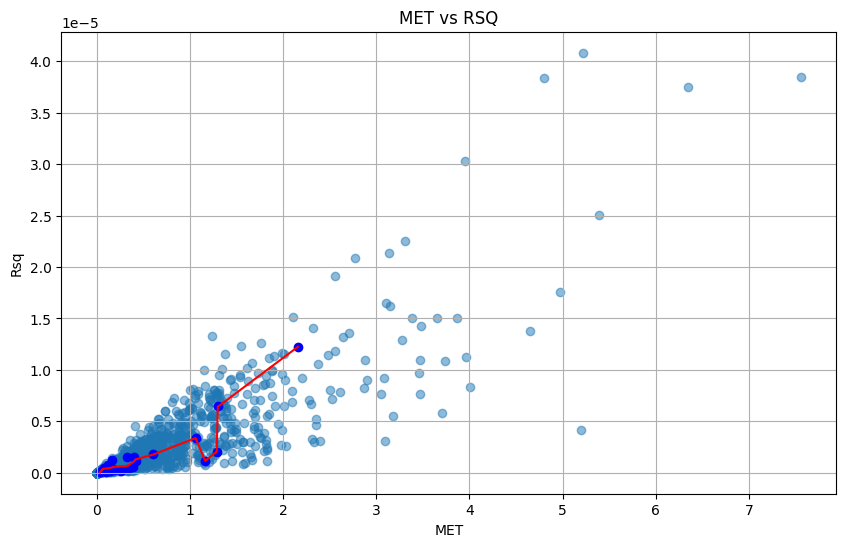

In [165]:
df = pd.read_csv('sim_with_razor.csv')

if len(df) > 1000:
    df_sampled = df.sample(n=10000, random_state=1)
else:
    df_sampled = df

# Graph MET vs RSQ
plt.figure(figsize=(10, 6))
plt.scatter(df_sampled['MET'], df_sampled['Rsq'], alpha=0.5)
plt.title('MET vs RSQ')
plt.scatter(MET, Rsq, color='blue', label='Actual data')
plt.plot(MET_sorted, Rsq_pred_poly_sorted, color='red', label='Quadratic regression curve')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.grid(True)
plt.show()

In [166]:
coefficients = model_poly.coef_
intercept = model_poly.intercept_

a = coefficients[4]
b = coefficients[3]
c = coefficients[2]
d = coefficients[1]
e = intercept

quadratic_equation = f'y = {a}x^4 + {b}x^3 + {c}x^2 + {d}x + {e}'
quadratic_equation

dataset = pd.read_csv('sim_with_razor.csv')
dataset = dataset[dataset['MET'] != 0]

In [167]:
def decode_individual(individual):
    # Convert the binary string to an integer. No need for modulo if individuals are correctly sized.
    return int(''.join(map(str, individual)), 2)

def check_closeness(individual):
    decoded_value = decode_individual(individual)
    
    filtered_data = dataset.loc[dataset['Event Number'] == decoded_value]
    # print(f'index: {decoded_value}, {filtered_data}')
    
    mse = 0
    
    if not filtered_data.empty:
        met_value = filtered_data.iloc[0]['MET'].reshape(1, -1)
        rsq_value = filtered_data.iloc[0]['Rsq']
        print(f'Index: {decoded_value}, MET: {met_value}, RSQ: {rsq_value}')
        
        predicted_Rsq_values = model_poly.predict(met_value)  # Evaluate polynomial at MET values
        residuals = rsq_value - predicted_Rsq_values  # Calculate residuals
        
        mse = np.mean(residuals**2)

    return mse
        
    
    
    # MET_val_transformed = poly.transform([[decoded_value]])
    
    # Rsq_pred = model_poly.predict(MET_val_transformed)[0]

    # return (Rsq_pred,)

In [168]:
required_bits = math.ceil(math.log2(500000))
BASE_LENGTH = required_bits
POPULATION_SIZE = 1000

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, BASE_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", check_closeness)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/Users/rohanarni/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/rohanarni/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [169]:
def run_ga(NGEN=100, CXPB=0.7, MUTPB=0.2):
    pop = toolbox.population(n=POPULATION_SIZE)

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for gen in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    return pop

def get_outlier_data(population):
    outlier_indices = [decode_individual(ind) for ind in population if ind.fitness.values[0] > 0] # Get the indices of the outliers
    outlier_indices = list(set(outlier_indices)) # Remove duplicates
    
    return dataset.iloc[outlier_indices] # Return the outlier data

In [170]:
final_population = run_ga(CXPB=0.7, MUTPB=0.2, NGEN=100)
top_individuals = sorted(final_population, key=lambda x: x.fitness.values[0], reverse=True)
top_individuals

Index: 263115, MET: [[0.114553]], RSQ: 1.693560864498741e-07


ValueError: X has 1 features, but LinearRegression is expecting 11 features as input.